In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, Statistics, PyPlot

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");
# workspace()

In [3]:
function average_percentage_deviation(predicted_prop, exptl_prop)

    # Check if the vectors have the same length
    length(predicted_prop) == length(exptl_prop) || throw(ArgumentError("Vectors must have the same length"))

    # Calculate the percentage deviation for each pair of corresponding elements
    percentage_deviations = 100 * abs.((predicted_prop .- exptl_prop) ./ exptl_prop)

    # Calculate the average percentage deviation
    average_percentage_deviation = mean(percentage_deviations)

    return average_percentage_deviation
end;

function average_absolute_deviation(predicted_prop, exptl_prop)

    # Check if the vectors have the same length
    length(predicted_prop) == length(exptl_prop) || throw(ArgumentError("Vectors must have the same length"))

    # Calculate the absolute percentage deviation for each pair of corresponding elements
    absolute_deviations = abs.(predicted_prop .- exptl_prop)

    # Calculate the average percentage deviation
    average_absolute_deviation = mean(absolute_deviations)

    return average_absolute_deviation
end;

In [4]:
n_props = 4;

AAD_storage = DataFrame(
    property = fill("abc", n_props),
    clip_points_train = fill(0.0, n_props),
    clip_points_val = fill(0.0, n_props),
    ignore_points_train = fill(0.0, n_props),
    ignore_points_val = fill(0.0, n_props),
    Tr_Tc_points_train = fill(0.0, n_props),
    Tr_Tc_points_val = fill(0.0, n_props),
) ;

AAD_storage.property = ["Sat. Vap. Specific Volume","Sat. Liq. Specific Volume","Saturated Pressures","Isochoric Heat Capacity"];

AAD_storage;

In [5]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [6]:
files = [
    "../jobs/23_updated_Clapeyron/5_clip_points_strat1/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat3/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat4/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat5/params_log.csv"
];

# files = [
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat5/params_log.csv"
# ];

# files = [
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat5/params_log.csv"
# ];

In [9]:
# This cell computes train and val data simultaneously, but the output is averages

folds = ["val"]
colours = ["#5dc90a","#08298a"]
n_points = 50
# Specify the range of experimental data to be plotted
plot_all_exptl_data = "no"
isobaric_heat_capacity_p = 10^5

folds_vsat_l_APDs_val = []
folds_vsat_v_APDs_val = []
folds_psat_APDs_val = []
folds_cp_APDs_val = []

folds_vsat_l_APDs_train = []
folds_vsat_v_APDs_train = []
folds_psat_APDs_train = []
folds_cp_APDs_train = []

for k in files

    raw_params = CSV.read(k, DataFrame, header=1)

    # specify analysis range
    last_n_rows = 0; # plot the last n epochs, set to 0 to ignore
    start_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore
    end_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore

    # create processed_data dataframe
    rename!(raw_params, :Column9 => :split)
    rename!(raw_params, :name => :species)
    unique_values = unique(raw_params[!, :species])
    num_rows = length(unique_values)

    processed_data = DataFrame(
        species = fill(missing, num_rows),
        isomeric_SMILES = fill("", num_rows),
        Mw = fill(0.0, num_rows),
        m = fill([0.0], num_rows), 
        σ = fill([0.0], num_rows),
        λ_a = fill([0.0], num_rows),
        λ_r = fill([0.0], num_rows),
        ϵ = fill([0.0], num_rows),
        split = fill("abc", num_rows)
    ) ;

    processed_data.species = unique_values;

    num_epochs_plotting = 0
    vmin = 0
    vmax = 0

    for i in unique_values
        raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
        num_epochs_plotting = nrow(raw_params_spec)

        row_number_processed = findall(isequal(i), processed_data.species)
        row_number_source = findall(isequal(i), pcp_source_params.common_name)

        processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
        processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
        processed_data[row_number_processed,:split] = [raw_params_spec[1,:split]]

        if start_row_interval ≠ 0 && end_row_interval ≠ 0
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = start_row_interval:end_row_interval]]
            num_epochs_plotting = end_row_interval - start_row_interval + 1
            vmin = start_row_interval
            vmax = end_row_interval

        elseif last_n_rows ≠ 0
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            vmin = num_epochs_plotting - last_n_rows + 1
            vmax = num_epochs_plotting

            num_epochs_plotting = last_n_rows

        else
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs_plotting]]
            vmin = 1
            vmax = num_epochs_plotting
        end
        
    end

    processed_data = sort(processed_data, :Mw);
    # println(num_epochs_plotting)

    for j = 1:length(folds)

        fold = folds[j]

        processed_data_split = filter(row -> row.split == fold, processed_data)
        species_to_filter = processed_data_split.species

        source_data_split = filter(row -> row.split == fold, processed_data)
        pcp_source_params_split = filter(row -> lowercase(row.common_name) in species_to_filter, pcp_source_params);

        # Calculate and plot APDs
        species = processed_data_split.species

        species = [x for x in species if x != "methane"]

        set_vsat_l_APDs = []
        set_vsat_v_APDs = []
        set_psat_APDs = []
        set_cp_APDs = []
        Mrs = []

        for i = 1:length(species)

            species_i = species[i]

            println(species_i)

            v_liq_range_pcp = []
            v_vap_range_pcp = []
            p_range_pcp = []
            cp_range_pcp = []
            v_liq_range_vrmie = []
            v_vap_range_vrmie = []
            p_range_vrmie = []
            cp_range_vrmie = []

            processed_data_test_species = filter(row -> row.species == lowercase(species_i), processed_data_split);
            source_data_test_species = filter(row -> row.common_name == lowercase(species_i), pcp_source_params_split);
            
            pcp_model = PPCSAFT([species_i])
            Tc_pcp, pc_pcp, Vc_pcp = crit_pure(pcp_model)
            
            # set experimental data range
            if plot_all_exptl_data == "no"
                T_range = collect(range(source_data_test_species.expt_T_min_liberal[1], min(500, 0.95*Tc_pcp,source_data_test_species.expt_T_max_conservative[1]), n_points))
                # T_range_plot = vcat(T_range_pcp, T_range_pcp)
            else
                T_range = collect(range(min(source_data_test_species.expt_T_min_liberal[1],0.5 * Tc_pcp), Tc_pcp, n_points))
                # T_range_plot = vcat(T_range_pcp, Tc_pcp, T_range_pcp)
            end
            
            # compute pseudo-experimental data
            for T in T_range
                (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
                cp_pcp = isobaric_heat_capacity(pcp_model, isobaric_heat_capacity_p, T)
                push!(v_liq_range_pcp, v_liq_sat)
                push!(v_vap_range_pcp, v_vap_sat)
                push!(p_range_pcp,p_sat)
                push!(cp_range_pcp,cp_pcp)
            end

            # Compute vr mie things
            Mw_test_species = processed_data_test_species[1,:Mw]
            m_test_species = processed_data_test_species[1,:m][end]
            σ_test_species = processed_data_test_species[1,:σ][end]
            λ_a_test_species = processed_data_test_species[1,:λ_a][end]
            λ_r_test_species = processed_data_test_species[1,:λ_r][end]
            ϵ_test_species = processed_data_test_species[1,:ϵ][end]
            
            vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)
            
            Tc0 = BigFloat.(Clapeyron.x0_crit_pure(vrmie_model))
            options = Clapeyron.NEqOptions(maxiter=20_000)
            Tc_vrmie, pc_vrmie, Vc_vrmie = Float64.(crit_pure(vrmie_model, Tc0; options=options))
                    
            for T in T_range
                if isempty(v_liq_range_vrmie)
                    method = ChemPotVSaturation()
                else
                    method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
                end
                (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
                cp_vrmie = isobaric_heat_capacity(vrmie_model, isobaric_heat_capacity_p, T)
                push!(v_liq_range_vrmie, v_liq_sat)
                push!(v_vap_range_vrmie, v_vap_sat)
                push!(p_range_vrmie, p_sat)
                push!(cp_range_vrmie, cp_vrmie)
            end 

            # Find indices of NaNs in array1
            cp_nan_indices = findall(isnan, cp_range_pcp)

            # Remove elements at NaN indices in array2
            cp_range_vrmie = cp_range_vrmie[setdiff(1:length(cp_range_vrmie), cp_nan_indices)]
            cp_range_pcp = cp_range_pcp[setdiff(1:length(cp_range_pcp), cp_nan_indices)]

            num_nan = count(x -> isnan(x), v_vap_range_vrmie)
            # num_nancp = count(x -> isnan(x), cp_range_vrmie)

            v_vap_range_vrmie = v_vap_range_vrmie[1:end-num_nan]
            v_vap_range_pcp = v_vap_range_pcp[1:end-num_nan]
            v_liq_range_vrmie = v_liq_range_vrmie[1:end-num_nan]
            v_liq_range_pcp = v_liq_range_pcp[1:end-num_nan]
            p_range_vrmie = p_range_vrmie[1:end-num_nan]
            p_range_pcp = p_range_pcp[1:end-num_nan]
            # cp_range_vrmie = cp_range_vrmie[1:end-num_nancp]
            # cp_range_pcp = cp_range_pcp[1:end-num_nancp]

            v_sat_l_APD = average_percentage_deviation(v_liq_range_vrmie, v_liq_range_pcp)
            v_sat_v_APD = average_percentage_deviation(v_vap_range_vrmie, v_vap_range_pcp)
            p_sat_APD = average_percentage_deviation(p_range_vrmie, p_range_pcp)
            cp_sat_APD = average_percentage_deviation(cp_range_vrmie, cp_range_pcp)

            push!(set_vsat_l_APDs, v_sat_l_APD)
            push!(set_vsat_v_APDs, v_sat_v_APD)
            push!(set_psat_APDs, p_sat_APD)
            push!(set_cp_APDs, cp_sat_APD)
            push!(Mrs, processed_data_test_species.Mw)

        end

        if j == 1
            push!(folds_vsat_v_APDs_train,mean(set_vsat_v_APDs))
            push!(folds_vsat_l_APDs_train,mean(set_vsat_l_APDs))
            push!(folds_psat_APDs_train,mean(set_psat_APDs))
            push!(folds_cp_APDs_train,mean(set_cp_APDs))
        else
            push!(folds_vsat_v_APDs_val,mean(set_vsat_v_APDs))
            push!(folds_vsat_l_APDs_val,mean(set_vsat_l_APDs))
            push!(folds_psat_APDs_val,mean(set_psat_APDs))
            push!(folds_cp_APDs_val,mean(set_cp_APDs))
        end

        println(mean(set_vsat_l_APDs))
        println(mean(set_vsat_v_APDs))
        println(mean(set_psat_APDs))
        println(mean(set_cp_APDs))
        
    end
    
end


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


2-methylbutane
2-methylpentane
2,2,3-trimethylbutane
heptane
3,4-dimethylhexane
3-methyl-3-ethylpentane
2,2,4-trimethylpentane
2,4,4-trimethylhexane
2,3,3,4-tetramethylpentane
decane
2-methyldecane
dodecane
3-methyltridecane
hexadecane
eicosane
3.692521476216947
97.00088041175295
70.49348985238083
9.003923618032275
Any[]


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


ethane
2,2-dimethylpropane
2,2-dimethylbutane
2,3-dimethylpentane
2,4-dimethylpentane
3-methylheptane
2-methyl-3-ethyl-pentane
2,4-dimethylhexane
2,2,3,4-tetramethylpentane
2,2,5-trimethylhexane
2,6-dimethyloctane
2,3-dimethylnonane
3-methyldodecane
2,3-dimethyldodecane
2,2,4,4,6,8,8-heptamethylnonane
tetracosane
7.886745411752605
214.41557869904653
47.56708958314712
12.229829692931569
Any[]


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


propane
pentane
2,3-dimethylbutane
3-methylhexane
2,5-dimethylhexane
2,2,3-trimethylpentane
2,3,3-trimethylpentane
4-methylheptane
3,3-diethylpentane
2,3-dimethylheptane
2,7-dimethyloctane
3-methylundecane
tridecane
tetradecane
heptadecane
heptacosane
7.128015529337608
151.791576125492
53.43131916432313
11.629142309058164
Any[]


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


n-butane
3-methylpentane
3-ethylpentane
3,3-dimethylpentane
2-methylheptane
octane
3-ethylhexane
2,3-dimethylhexane
2-methyloctane
2,2,3,3-tetramethylpentane
3-methyldecane
2,3-dimethyldecane
2-methyldodecane
2-methyltridecane
octadecane
octacosane
8.52091800713082
155.86955052915167
88.7704282656511
11.103710329756332
Any[]


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


2-methylpropane
hexane
2-methylhexane
2,2-dimethylpentane
3,3-dimethylhexane
2,3,4-trimethyl pentane
2,2-dimethylhexane
nonane
2,2,4,4-tetramethylpentane
2,2,5,5-tetramethylhexane
n-undecane
2-methylundecane
2,3-dimethylundecane
pentadecane
nonadecane
squalane
8.450715369927662
34.25459301034395
96.99836975133829
6.326568600276305
Any[]


In [ ]:
push!(folds_vsat_v_APDs_val,mean(set_vsat_v_APDs))
push!(folds_vsat_l_APDs_val,mean(set_vsat_l_APDs))
push!(folds_psat_APDs_val,mean(set_psat_APDs))
push!(folds_cp_APDs_val,mean(set_cp_APDs))

In [8]:
@show folds_vsat_v_APDs_val
@show folds_vsat_l_APDs_val
@show folds_psat_APDs_val
@show folds_cp_APDs_val

folds_vsat_v_APDs_val = Any[]
folds_vsat_l_APDs_val = Any[]
folds_psat_APDs_val = Any[]
folds_cp_APDs_val = Any[]


Any[]

In [59]:
AAD_storage[1,:clip_points_train] = mean(folds_vsat_v_APDs_train)
AAD_storage[2,:clip_points_train] = mean(folds_vsat_l_APDs_train)
AAD_storage[3,:clip_points_train] = mean(folds_psat_APDs_train)
AAD_storage[4,:clip_points_train] = mean(folds_cp_APDs_train)

AAD_storage[1,:clip_points_val] = mean(folds_vsat_v_APDs_val)
AAD_storage[2,:clip_points_val] = mean(folds_vsat_l_APDs_val)
AAD_storage[3,:clip_points_val] = mean(folds_psat_APDs_val)
AAD_storage[4,:clip_points_val] = mean(folds_cp_APDs_val)

# AAD_storage[1,:ignore_points_train] = mean(folds_vsat_v_APDs_train)
# AAD_storage[2,:ignore_points_train] = mean(folds_vsat_l_APDs_train)
# AAD_storage[3,:ignore_points_train] = mean(folds_psat_APDs_train)
# AAD_storage[4,:ignore_points_train] = mean(folds_cp_APDs_train)

# AAD_storage[1,:ignore_points_val] = mean(folds_vsat_v_APDs_val)
# AAD_storage[2,:ignore_points_val] = mean(folds_vsat_l_APDs_val)
# AAD_storage[3,:ignore_points_val] = mean(folds_psat_APDs_val)
# AAD_storage[4,:ignore_points_val] = mean(folds_cp_APDs_val)

# AAD_storage[1,:Tr_Tc_points_train] = mean(folds_vsat_v_APDs_train)
# AAD_storage[2,:Tr_Tc_points_train] = mean(folds_vsat_l_APDs_train)
# AAD_storage[3,:Tr_Tc_points_train] = mean(folds_psat_APDs_train)
# AAD_storage[4,:Tr_Tc_points_train] = mean(folds_cp_APDs_train)

# AAD_storage[1,:Tr_Tc_points_val] = mean(folds_vsat_v_APDs_val)
# AAD_storage[2,:Tr_Tc_points_val] = mean(folds_vsat_l_APDs_val)
# AAD_storage[3,:Tr_Tc_points_val] = mean(folds_psat_APDs_val)
# AAD_storage[4,:Tr_Tc_points_val] = mean(folds_cp_APDs_val)


10.045331725968044

In [60]:
AAD_storage

Row,property,clip_points_train,clip_points_val,ignore_points_train,ignore_points_val,Tr_Tc_points_train,Tr_Tc_points_val
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Sat. Vap. Specific Volume,192.474,130.341,143.12,131.107,602.314,219.978
2,Sat. Liq. Specific Volume,4.42865,7.36937,4.65564,7.58783,4.37055,8.00096
3,Saturated Pressures,9.69387,70.672,10.996,72.3588,178.01,136.01
4,Isochoric Heat Capacity,5.89575,10.0453,6.16817,10.3177,7.40234,10.8647


In [61]:
# CSV.write("AADs_five_fold_cross_val_methane_removed.csv", AAD_storage) ;

In [10]:
files_for_val = [
    "../jobs/23_updated_Clapeyron/5_clip_points_strat1/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat3/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat4/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat5/params_log.csv"
];

# files_for_val = [
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat5/params_log.csv"
# ];

# files_for_val = [
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat5/params_log.csv"
# ];

In [12]:
# This examines val data only, generating a dataframe containing all compounds
# Validaton data is extracted over multiple files

n_points = 50
remove_methane = false

# Specify the range of experimental data to be plotted
plot_all_exptl_data = false

# Computed data properties
isobaric_heat_capacity_p = 10^5

colours = ["#5dc90a","#08298a"]

# this file is not further processed; it's just to determine the number of species being analysed
raw_params_dummy = CSV.read("../jobs/23_updated_Clapeyron/5_clip_points_strat5/params_log.csv", DataFrame, header=1)

species = unique(raw_params_dummy[!, :name])

if remove_methane == true
    species = [x for x in species if x != "methane"]
end

num_rows = length(species)

println(num_rows)

val_data_summary = DataFrame(
    common_name = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    APD_vsat_l = fill(0.0, num_rows),
    APD_vsat_v = fill(0.0, num_rows),
    APD_psat = fill(0.0, num_rows),
    APD_cp = fill(0.0, num_rows),
) ;

val_data_summary.common_name = species
row_counter_data_gen = 1

for k in files_for_val

    raw_params = CSV.read(k, DataFrame, header=1)

    # specify analysis range
    last_n_rows = 0; # plot the last n epochs, set to 0 to ignore
    start_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore
    end_row_interval = 0; # plot epoch range starting from this value, set to 0 to ignore

    # create processed_data dataframe
    rename!(raw_params, :Column9 => :split)
    rename!(raw_params, :name => :species)
    unique_values_raw_params = unique(raw_params[!, :species])
    num_rows_raw_params = length(unique_values_raw_params)

    processed_data = DataFrame(
        species = fill(missing, num_rows_raw_params),
        isomeric_SMILES = fill("", num_rows_raw_params),
        Mw = fill(0.0, num_rows_raw_params),
        m = fill([0.0], num_rows_raw_params), 
        σ = fill([0.0], num_rows_raw_params),
        λ_a = fill([0.0], num_rows_raw_params),
        λ_r = fill([0.0], num_rows_raw_params),
        ϵ = fill([0.0], num_rows_raw_params),
        split = fill("", num_rows_raw_params)
    ) ;

    processed_data.species = unique_values_raw_params;

    num_epochs_plotting = 0
    vmin = 0
    vmax = 0

    for i in unique_values_raw_params
        raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
        num_epochs_plotting = nrow(raw_params_spec)

        row_number_processed = findall(isequal(i), processed_data.species)
        row_number_source = findall(isequal(i), pcp_source_params.common_name)

        processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
        processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
        processed_data[row_number_processed,:split] = [raw_params_spec[1,:split]]

        if start_row_interval ≠ 0 && end_row_interval ≠ 0
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = start_row_interval:end_row_interval]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = start_row_interval:end_row_interval]]
            num_epochs_plotting = end_row_interval - start_row_interval + 1
            vmin = start_row_interval
            vmax = end_row_interval

        elseif last_n_rows ≠ 0
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = num_epochs_plotting - last_n_rows + 1:num_epochs_plotting]]
            vmin = num_epochs_plotting - last_n_rows + 1
            vmax = num_epochs_plotting

            num_epochs_plotting = last_n_rows

        else
            processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs_plotting]]
            processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs_plotting]]
            vmin = 1
            vmax = num_epochs_plotting
        end
        
    end

    processed_data = sort(processed_data, :Mw)

    # filter validation data from each fold
    processed_data_split = filter(row -> row.split == "val", processed_data)

    species_to_filter = processed_data_split.species
    pcp_source_params_split = filter(row -> lowercase(row.common_name) in species_to_filter, pcp_source_params);

    # source_data_split = filter(row -> row.split == "val", processed_data)

    if remove_methane == true
        species_to_filter = [x for x in species_to_filter if x != "methane"]
    end

    for i = 1:length(species_to_filter)

        species_i = species_to_filter[i]

        # println(species_i)

        v_liq_range_pcp = []; v_liq_range_vrmie = []
        v_vap_range_pcp = []; v_vap_range_vrmie = []
        p_range_pcp = []; p_range_vrmie = []
        cp_range_pcp = []; cp_range_vrmie = []        

        processed_data_test_species = filter(row -> row.species == lowercase(species_i), processed_data_split);
        source_data_test_species = filter(row -> row.common_name == lowercase(species_i), pcp_source_params_split);
        
        # Create PCP-SAFT model
        pcp_model = PPCSAFT([species_i])

        # Create SAFT-VR Mie model
        Mw_test_species = processed_data_test_species[1,:Mw]
        m_test_species = processed_data_test_species[1,:m][end]
        σ_test_species = processed_data_test_species[1,:σ][end]
        λ_a_test_species = processed_data_test_species[1,:λ_a][end]
        λ_r_test_species = processed_data_test_species[1,:λ_r][end]
        ϵ_test_species = processed_data_test_species[1,:ϵ][end]
        vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

        (T_sat_pcp_10Pa, v_liq_sat_pcp_10Pa, v_vap_sat_pcp_10Pa) = saturation_temperature(pcp_model, 10) # compute saturated properties at 10Pa
        (T_sat_vrmie_10Pa, v_liq_sat_pcp10Pa, v_vap_sat_pcp_10Pa) = saturation_temperature(vrmie_model, 10) # compute saturated properties at 10Pa

        Tc_pcp, pc_pcp, Vc_pcp = crit_pure(pcp_model)
        
        # set experimental data range
        if plot_all_exptl_data == false
            # Tmin = max(T_sat_pcp_10Pa, T_sat_vrmie_10Pa, source_data_test_species.expt_T_min_liberal[1])
            Tmin = source_data_test_species.expt_T_min_liberal[1]
            Tmax = min(500, 0.95*Tc_pcp,source_data_test_species.expt_T_max_conservative[1])
            T_range = collect(range(Tmin, Tmax, n_points))
        else
            # Tmin = max(T_sat_pcp_10Pa, T_sat_vrmie_10Pa, min(source_data_test_species.expt_T_min_liberal[1],0.5 * Tc_pcp))
            Tmin = min(source_data_test_species.expt_T_min_liberal[1],0.5 * Tc_pcp)
            Tmax = Tc_pcp
            T_range = collect(range(Tmin, Tmax, n_points))
            # T_range_plot = vcat(T_range_pcp, Tc_pcp, T_range_pcp)
        end
        
        # compute pseudo-experimental data
        for T in T_range
            (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
            cp_pcp = isobaric_heat_capacity(pcp_model, isobaric_heat_capacity_p, T)
            push!(v_liq_range_pcp, v_liq_sat)
            push!(v_vap_range_pcp, v_vap_sat)
            push!(p_range_pcp,p_sat)
            push!(cp_range_pcp,cp_pcp)
        end
                
        # compute predicted data
        Tc0 = BigFloat.(Clapeyron.x0_crit_pure(vrmie_model))
        options = Clapeyron.NEqOptions(maxiter=20_000)
        Tc_vrmie, pc_vrmie, Vc_vrmie = Float64.(crit_pure(vrmie_model, Tc0; options=options))
                
        for T in T_range
            if isempty(v_liq_range_vrmie)
                method = ChemPotVSaturation()
            else
                method = ChemPotVSaturation(vl=last(v_liq_range_vrmie), vv=last(v_vap_range_vrmie))
            end
            (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T, method)
            cp_vrmie = isobaric_heat_capacity(vrmie_model, isobaric_heat_capacity_p, T)
            push!(v_liq_range_vrmie, v_liq_sat)
            push!(v_vap_range_vrmie, v_vap_sat)
            push!(p_range_vrmie, p_sat)
            push!(cp_range_vrmie, cp_vrmie)
        end 

        # Find indices and remove NaNs
        cp_nan_indices = findall(isnan, cp_range_pcp)
        cp_range_vrmie = cp_range_vrmie[setdiff(1:length(cp_range_vrmie), cp_nan_indices)]
        cp_range_pcp = cp_range_pcp[setdiff(1:length(cp_range_pcp), cp_nan_indices)]

        num_nan = count(x -> isnan(x), v_vap_range_vrmie)
        # num_nancp = count(x -> isnan(x), cp_range_vrmie)

        v_vap_range_vrmie = v_vap_range_vrmie[1:end-num_nan]
        v_vap_range_pcp = v_vap_range_pcp[1:end-num_nan]
        v_liq_range_vrmie = v_liq_range_vrmie[1:end-num_nan]
        v_liq_range_pcp = v_liq_range_pcp[1:end-num_nan]
        p_range_vrmie = p_range_vrmie[1:end-num_nan]
        p_range_pcp = p_range_pcp[1:end-num_nan]

        # println(v_vap_range_pcp)
        # println(v_vap_range_vrmie)
        # println(p_range_pcp)
        # println(cp_range_vrmie)

        # v_sat_l_APD = average_absolute_deviation(v_liq_range_vrmie, v_liq_range_pcp)
        # v_sat_v_APD = average_absolute_deviation(v_vap_range_vrmie, v_vap_range_pcp)
        # p_sat_APD = average_absolute_deviation(p_range_vrmie, p_range_pcp)
        # cp_sat_APD = average_absolute_deviation(cp_range_vrmie, cp_range_pcp)

        v_sat_l_APD = average_percentage_deviation(v_liq_range_vrmie, v_liq_range_pcp)
        v_sat_v_APD = average_percentage_deviation(v_vap_range_vrmie, v_vap_range_pcp)
        p_sat_APD = average_percentage_deviation(p_range_vrmie, p_range_pcp)
        cp_sat_APD = average_percentage_deviation(cp_range_vrmie, cp_range_pcp)

        val_data_summary[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
        val_data_summary[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
        val_data_summary[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
        val_data_summary[row_counter_data_gen,:APD_vsat_l] = v_sat_l_APD
        val_data_summary[row_counter_data_gen,:APD_vsat_v] = v_sat_v_APD
        val_data_summary[row_counter_data_gen,:APD_psat] = p_sat_APD
        val_data_summary[row_counter_data_gen,:APD_cp] = cp_sat_APD

        row_counter_data_gen += 1

    end
            
end

val_data_summary = sort(val_data_summary, :Mw);

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


80


┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ 

In [14]:
println(val_data_summary)

80×7 DataFrame
 Row │ common_name                      isomeric_SMILES                    Mw       APD_vsat_l  APD_vsat_v    APD_psat   APD_cp     
     │ String31                         String                             Float64  Float64     Float64       Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ methane                          C                                   16.031   10.2232       3.36369e6   99.6994   240.021
   2 │ ethane                           CC                                  30.047   26.4719      52.5424      36.2667    24.2174
   3 │ propane                          CCC                                 44.063   14.8416    1200.1         23.8227    16.6301
   4 │ n-butane                         CCCC                                58.078   11.9552      56.8548     138.942      7.80614
   5 │ 2-methylpropane                  CC(C)C                    

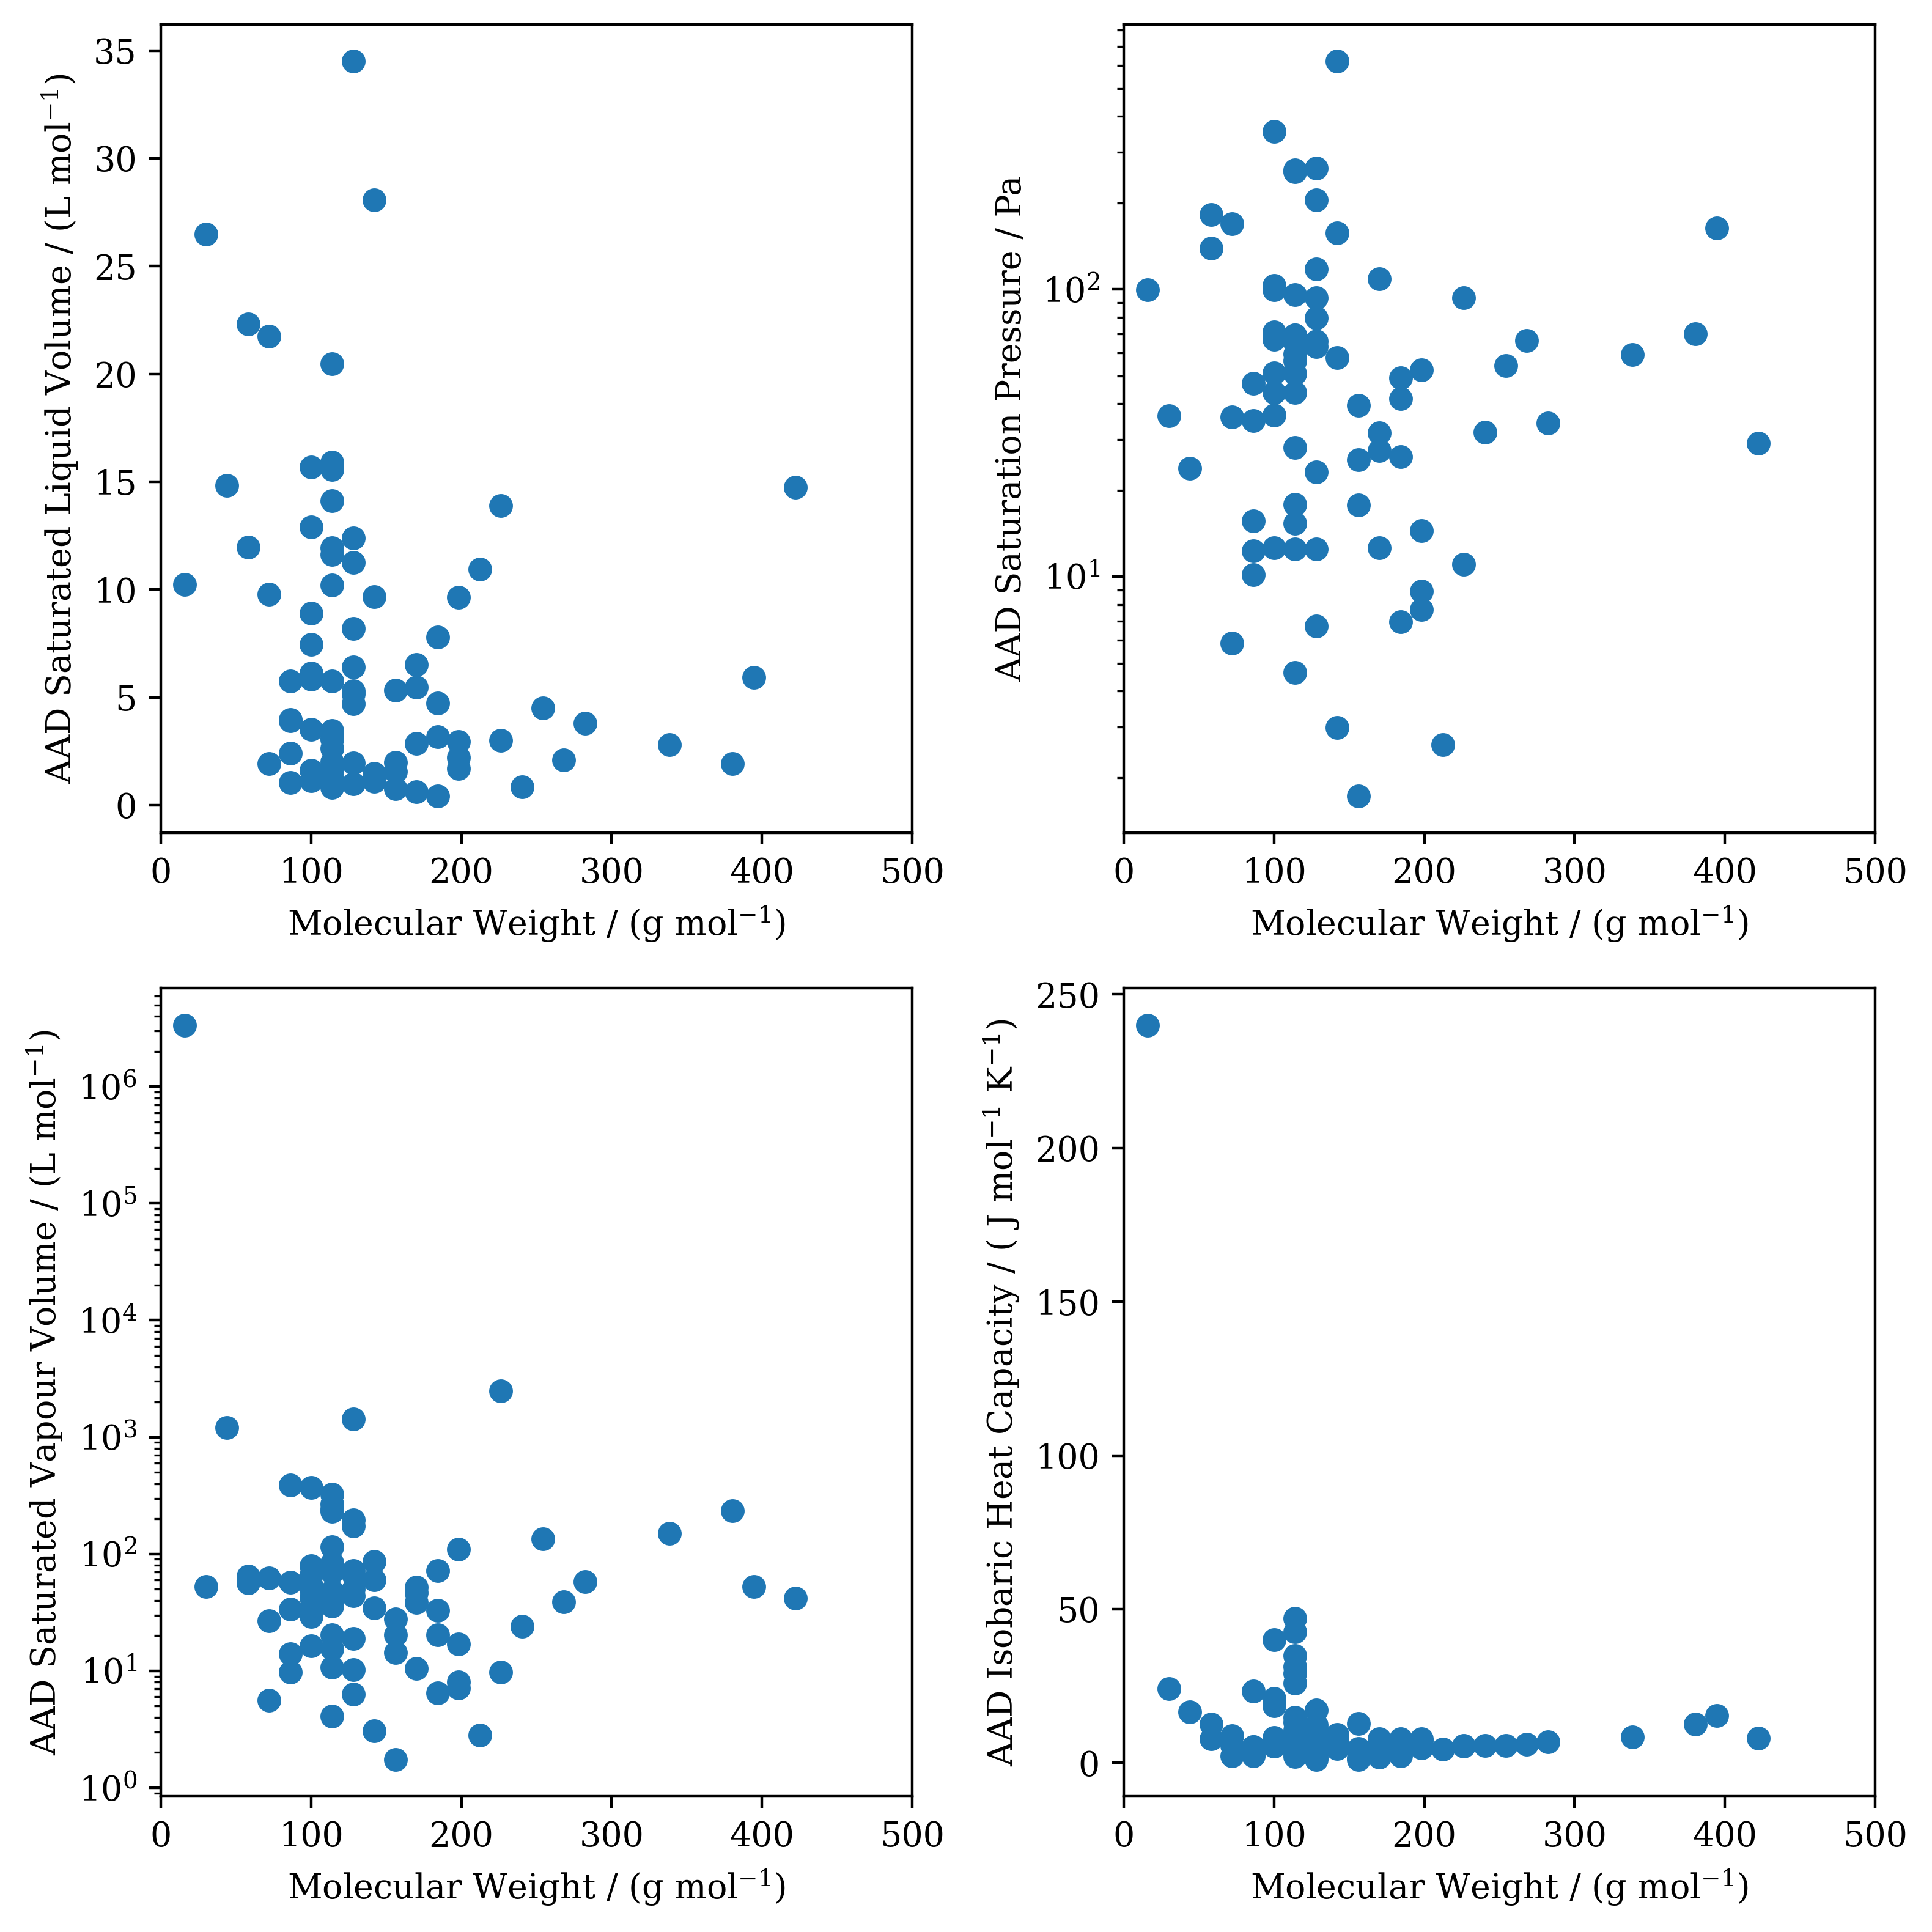

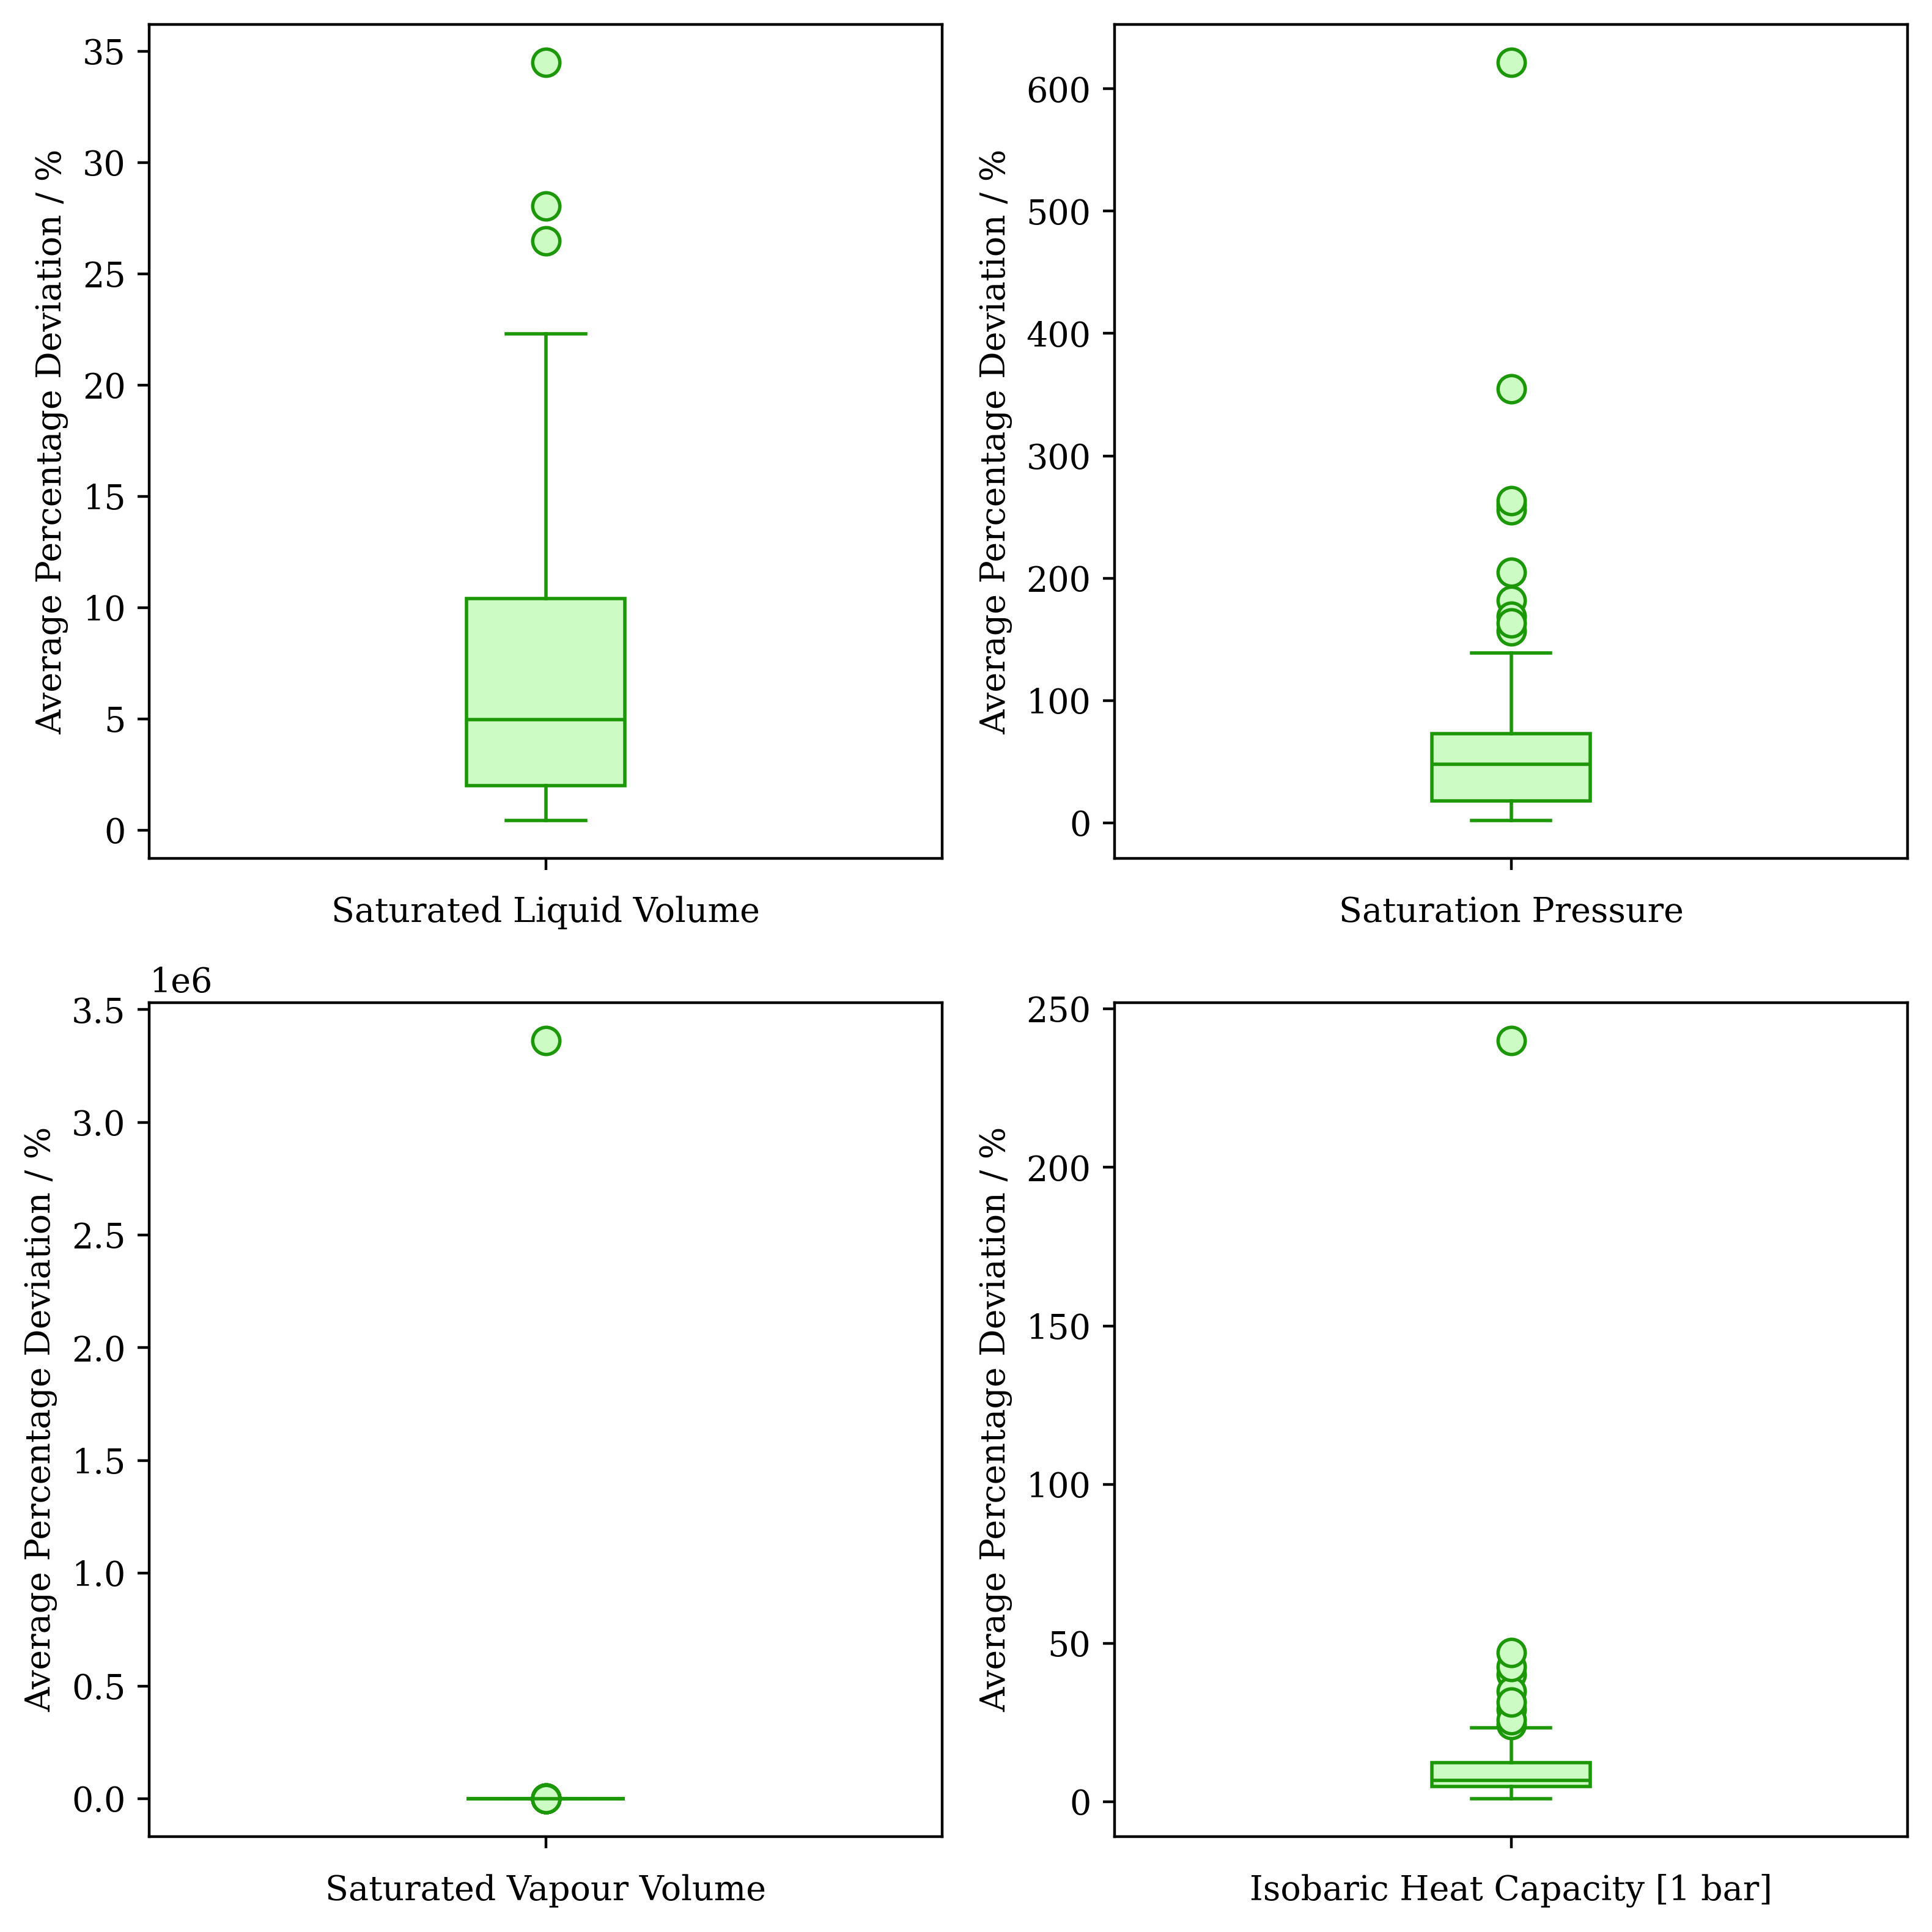

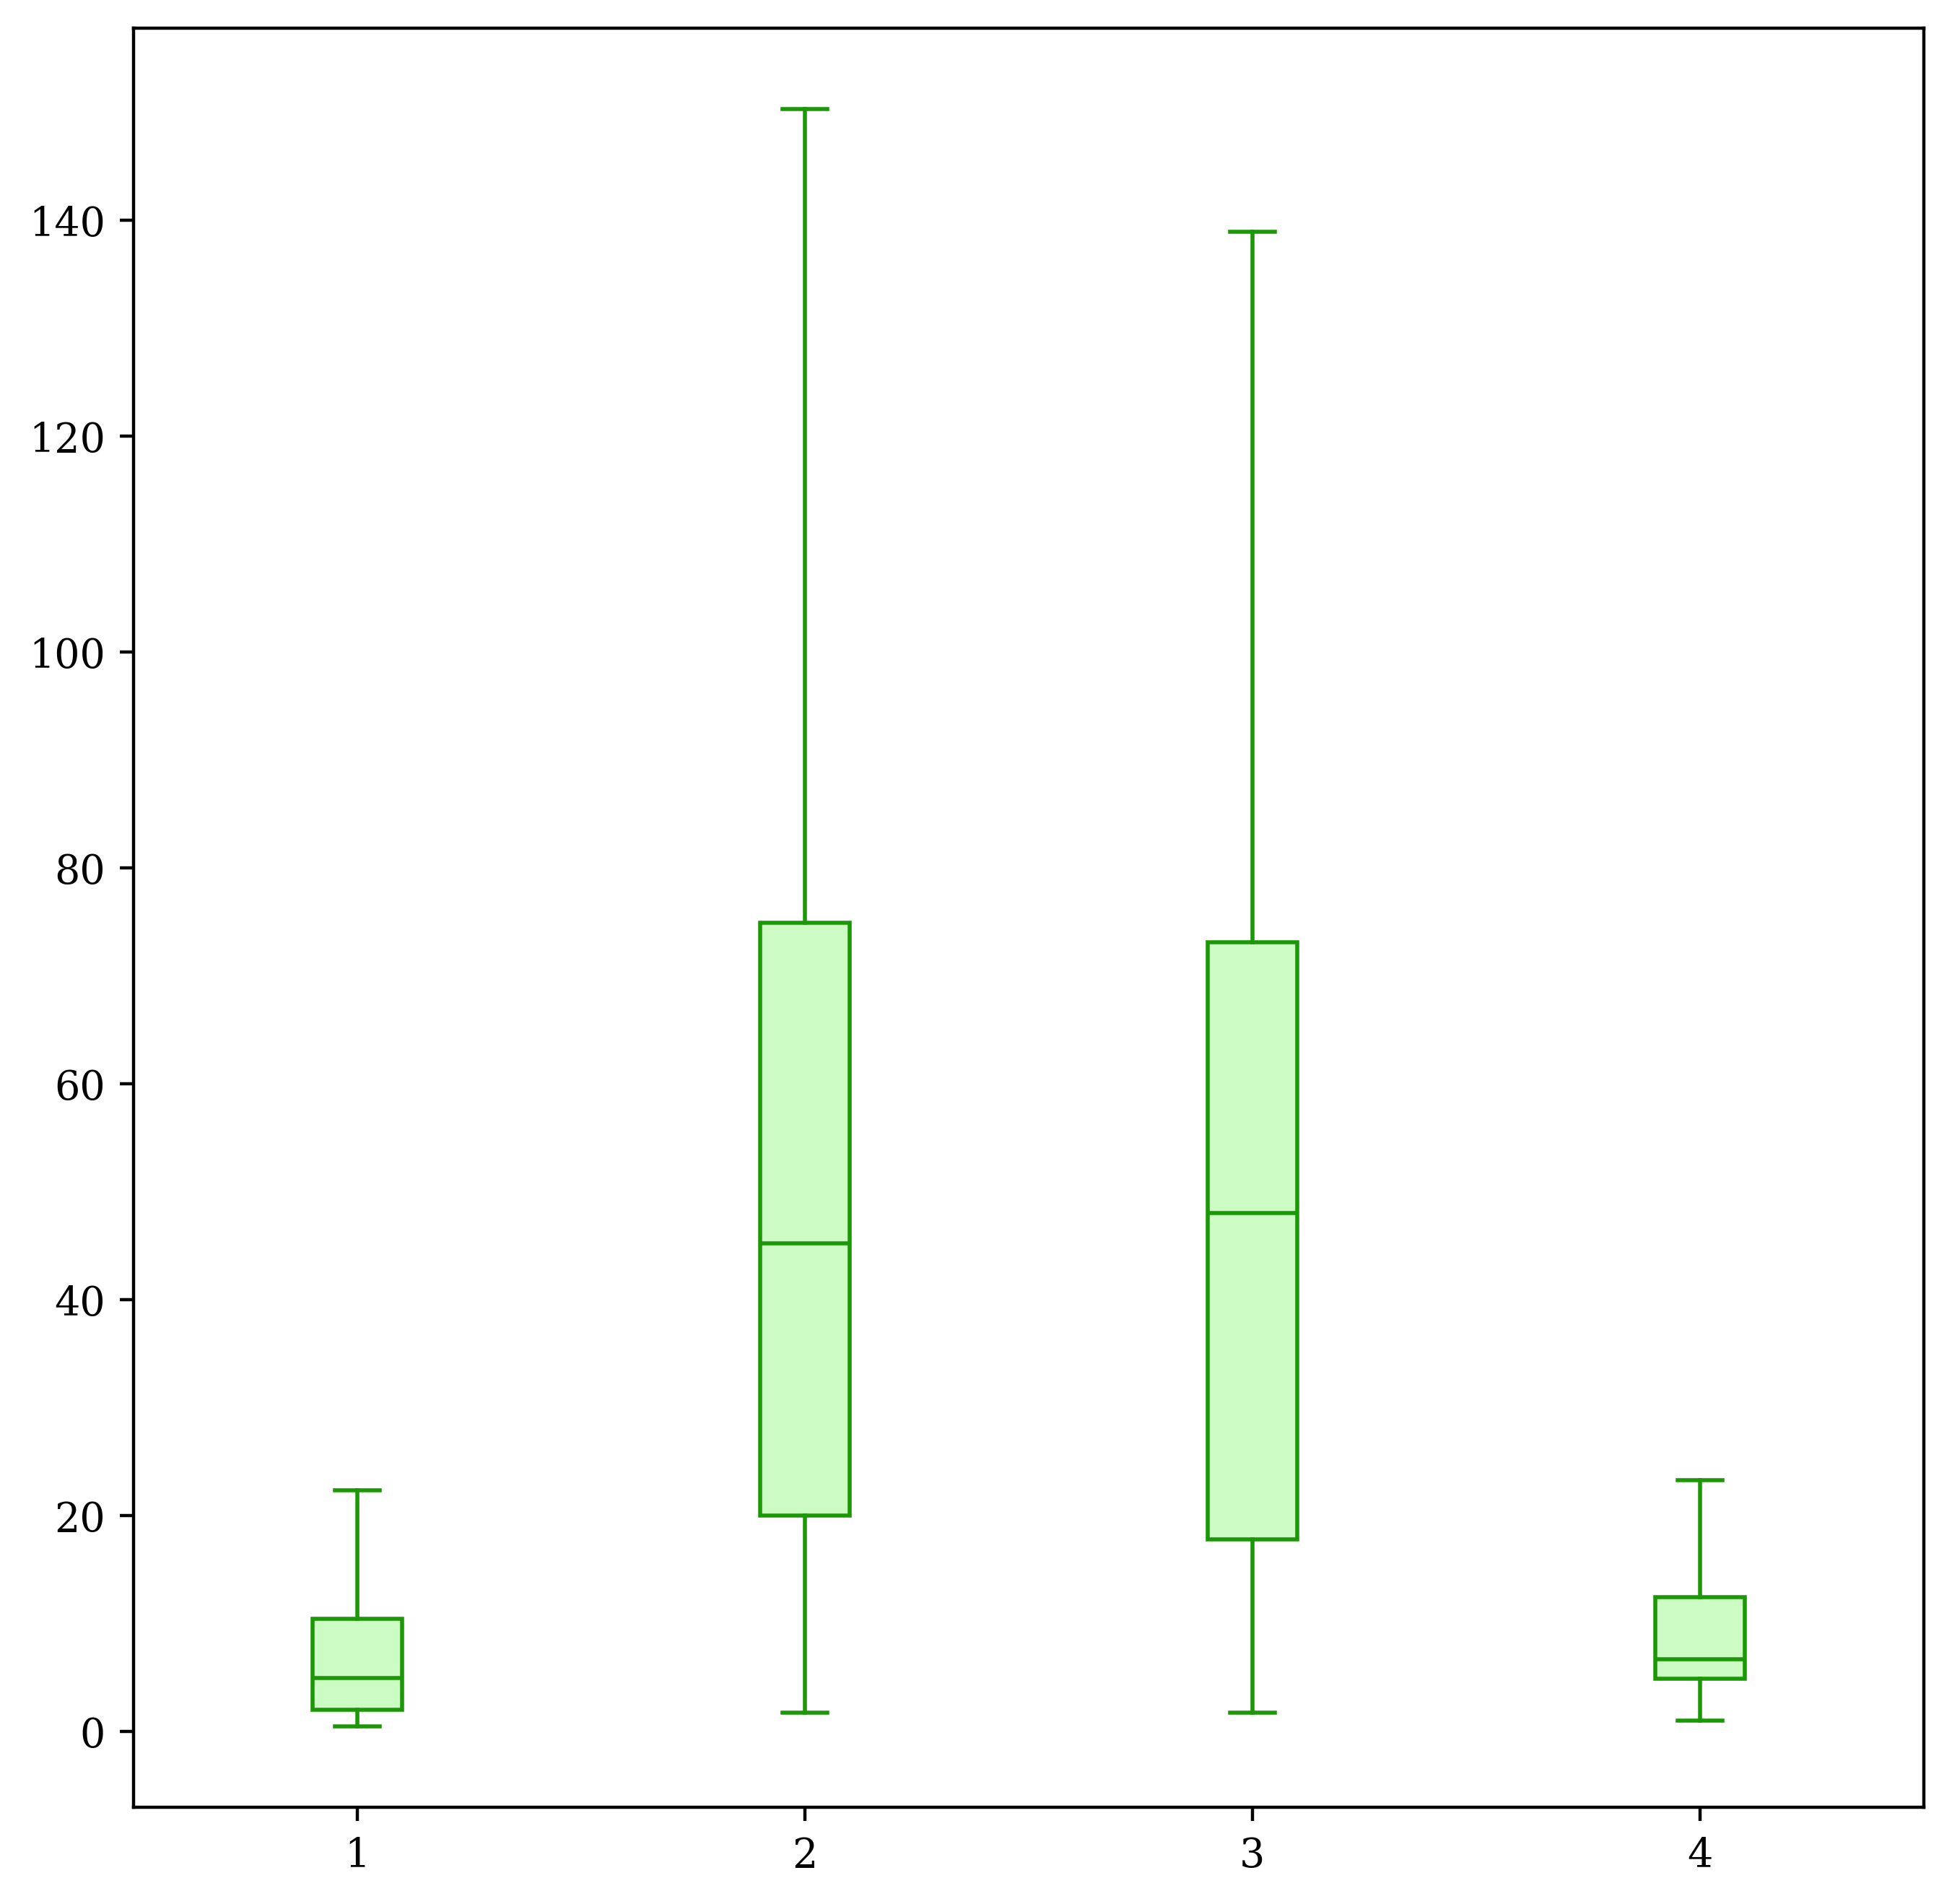

In [15]:
figure_1, axes_1 = plt.subplots(2,2, figsize=(8, 8), dpi=400)
figure_2, axes_2 = plt.subplots(2,2, figsize=(8, 8), dpi=400)
figure_3, axes_3 = plt.subplots(figsize=(8, 8), dpi=400)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=10)

axes_1[1].scatter(val_data_summary.Mw, val_data_summary.APD_vsat_l)
axes_1[2].scatter(val_data_summary.Mw, val_data_summary.APD_vsat_v)
axes_1[3].scatter(val_data_summary.Mw, val_data_summary.APD_psat)
axes_1[4].scatter(val_data_summary.Mw, val_data_summary.APD_cp)

axes_1[1].set_ylabel(L"AAD Saturated Liquid Volume / (L mol$\mathregular{^{-1}}$)")
axes_1[1].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[1].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[1].set_xlim([0, 500])

axes_1[2].set_ylabel(L"AAD Saturated Vapour Volume / (L mol$\mathregular{^{-1}}$)")
axes_1[2].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[2].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[2].set_xlim([0, 500])
axes_1[2].set_yscale("log")

axes_1[3].set_ylabel("AAD Saturation Pressure / Pa")
axes_1[3].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[3].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[3].set_xlim([0, 500])
axes_1[3].set_yscale("log")

axes_1[4].set_ylabel(L"AAD Isobaric Heat Capacity / ( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)")
axes_1[4].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[4].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[4].set_xlim([0, 500])



# Create a box plot with custom color and width
boxprops = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops = Dict("linewidth" => 1, "color" => "#1C9707")
capprops = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops = Dict("color" => "#1C9707")
box_width = 0.2


axes_2[1].boxplot(val_data_summary[!, 4], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)
axes_2[2].boxplot(val_data_summary[!, 5], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)
axes_2[3].boxplot(val_data_summary[!, 6], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)
axes_2[4].boxplot(val_data_summary[!, 7], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)

axes_2[1].set_xlabel("Saturated Liquid Volume")
axes_2[1].set_ylabel("Average Percentage Deviation / %")
axes_2[1].set_xticklabels("")

axes_2[2].set_xlabel("Saturated Vapour Volume")
axes_2[2].set_ylabel("Average Percentage Deviation / %")
axes_2[2].set_xticklabels("")

axes_2[3].set_xlabel("Saturation Pressure")
axes_2[3].set_ylabel("Average Percentage Deviation / %")
axes_2[3].set_xticklabels("")

axes_2[4].set_xlabel("Isobaric Heat Capacity [1 bar]")
axes_2[4].set_ylabel("Average Percentage Deviation / %")
axes_2[4].set_xticklabels("")

box_data_grouped = [val_data_summary[!, i] for i in [4,5,6,7]]#]:ncol(val_data_summary)]

axes_3.boxplot(box_data_grouped, boxprops=boxprops, showfliers=false,whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)


# axes_2.set_xticklabels(["Saturated Liquid Volume","Saturated Vapour Volume","Saturation Pressure","Isobaric Heat Capacity"],rotation=45)
# axes_2.set_ylabel("Average Percentage Deviation",fontsize=18)

# plt.xticks(fontsize=14, fontname="serif",rotation=40, ha="right")
# plt.yticks(fontsize=14, fontname="serif")
# plt.ylim([0,nothing])
# # axes_2.set_title

figure_1.tight_layout()
figure_2.tight_layout()

In [27]:
names(val_data_summary)




4-element Vector{String}:
 "common_name"
 "isomeric_SMILES"
 "Mw"
 "APD_vsat_l"